In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import torch

from tools import prepare, mixup, getCorrects

sys.path.append('../BAT/datasets/')

classes = {
    "Rhinolophus ferrumequinum": 0,
    "Rhinolophus hipposideros": 1,
    "Myotis daubentonii": 2,
    "Myotis brandtii": 3,
    "Myotis mystacinus": 4,
    "Myotis emarginatus": 5,
    "Myotis nattereri": 6,
    #"Myotis bechsteinii": 7,
    "Myotis myotis": 7,
    "Myotis dasycneme": 8,
    "Nyctalus noctula": 9,
    "Nyctalus leisleri": 10,
    "Pipistrellus pipistrellus": 11,
    "Pipistrellus nathusii": 12,
    "Pipistrellus kuhlii": 13,
    "Eptesicus serotinus": 14,
    "Eptesicus nilssonii": 15,
    #"Plecotus auritus": 16,
    #"Plecotus austriacus": 16,
    #"Barbastella barbastellus": 16,
    #"Tadarida teniotis": 16,
    "Miniopterus schreibersii": 16,
    #"Hypsugo savii": 18,
    "Vespertilio murinus": 17,
}

2022-11-08 14:12:34.148876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 14:12:34.583613: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 14:12:37.310133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2022-11-08 14:12:37.310425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

# Dataset

In [2]:
num_bands = 257
seq_len = 60
patch_len = 61 * 2816      # = 250ms ~ 25ms (0.5 * 44 * (512 // 4))
patch_skip = 15 * 2816          # 15 patches = 15 * 0.25 * 22050 * 0.5

data_path = "../BAT/datasets/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, classes, patch_len, patch_skip)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 19.88it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", len(X_train), X_train.shape, Y_train.shape)
print("Test sequences:", len(X_test), X_test.shape, Y_test.shape)
print("Validation sequences:", len(X_val), X_val.shape, Y_val.shape)

Total sequences: 19194
Train sequences: 11323 (11323, 171776) (11323,)
Test sequences: 4980 (4980, 171776) (4980,)
Validation sequences: 2891 (2891, 171776) (2891,)


# Model

In [4]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT import BigBAT

In [5]:
max_len = seq_len
batch_size = 64
epochs = 23
lr = .0005
warmup_epochs = 5
d_model = 64

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))

    
model = BigBAT(
    max_len=max_len,
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [6]:
train_len = batch_size * int(len(X_train) / batch_size)
test_len = batch_size * int(len(X_test) / batch_size)
val_len = batch_size * int(len(X_val) / batch_size)

train_data = TensorDataset(torch.Tensor(X_train[:train_len]), torch.from_numpy(Y_train[:train_len]))
test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
val_data = TensorDataset(torch.Tensor(X_val[:val_len]), torch.from_numpy(Y_val[:val_len]))

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [7]:
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0, disable_torch_grad_focal_loss=True)

base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
    
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [8]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)

        # Compute Loss
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights (SAM)
        optimizer.first_step()
        criterion(model(inputs), labels).backward()
        optimizer.second_step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += getCorrects(outputs, labels)
    
        # Perform learning rate step
        scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [9]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += getCorrects(outputs, labels)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

# Training

In [10]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout
}

wandb.init(project="BigBAT", entity="frankfundel", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)


In [12]:
restart_scheduler = 5
s_epoch = 0
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, s_epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, s_epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'BigBAT.pth')
    
    if s_epoch == restart_scheduler:
        s_epoch = 0
    else:
        s_epoch += 1

# Load after training
model.load_state_dict(torch.load('BigBAT.pth'))

==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████| 176/176 [02:01<00:00,  1.45it/s]

Training loss: 120.6862 Acc: 0.4014



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.06it/s]

Validation loss: 111.2702 Acc: 0.4990
val_loss decreased, saving model
==================== Starting at epoch 1 ====================



100%|█████████████████████████████████████████| 176/176 [01:58<00:00,  1.48it/s]

Training loss: 100.7921 Acc: 0.5209



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.15it/s]

Validation loss: 102.0749 Acc: 0.5545
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|█████████████████████████████████████████| 176/176 [02:01<00:00,  1.44it/s]

Training loss: 92.0240 Acc: 0.5774



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.24it/s]

Validation loss: 94.4332 Acc: 0.6068
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|█████████████████████████████████████████| 176/176 [02:03<00:00,  1.43it/s]

Training loss: 87.8948 Acc: 0.6095



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.30it/s]

Validation loss: 90.3701 Acc: 0.6571
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|█████████████████████████████████████████| 176/176 [01:59<00:00,  1.47it/s]

Training loss: 84.1609 Acc: 0.6309



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.35it/s]

Validation loss: 86.6212 Acc: 0.6739
val_loss decreased, saving model
==================== Starting at epoch 5 ====================



100%|█████████████████████████████████████████| 176/176 [01:59<00:00,  1.48it/s]

Training loss: 85.2082 Acc: 0.6291



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.29it/s]

Validation loss: 88.9620 Acc: 0.6724
==================== Starting at epoch 6 ====================



100%|█████████████████████████████████████████| 176/176 [01:59<00:00,  1.48it/s]

Training loss: 78.7407 Acc: 0.6648



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.14it/s]

Validation loss: 88.7780 Acc: 0.6519
==================== Starting at epoch 7 ====================



100%|█████████████████████████████████████████| 176/176 [02:01<00:00,  1.44it/s]

Training loss: 74.6564 Acc: 0.6943



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.16it/s]

Validation loss: 73.8920 Acc: 0.7251
val_loss decreased, saving model
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████| 176/176 [02:04<00:00,  1.41it/s]

Training loss: 70.2591 Acc: 0.7213



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.03it/s]

Validation loss: 74.9472 Acc: 0.7299
==================== Starting at epoch 9 ====================



100%|█████████████████████████████████████████| 176/176 [01:59<00:00,  1.48it/s]

Training loss: 66.7517 Acc: 0.7348



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.29it/s]

Validation loss: 71.0461 Acc: 0.7433
val_loss decreased, saving model
==================== Starting at epoch 10 ====================



100%|█████████████████████████████████████████| 176/176 [02:02<00:00,  1.43it/s]

Training loss: 65.1167 Acc: 0.7472



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.29it/s]

Validation loss: 69.8175 Acc: 0.7404
val_loss decreased, saving model
==================== Starting at epoch 11 ====================



100%|█████████████████████████████████████████| 176/176 [01:59<00:00,  1.47it/s]

Training loss: 70.0941 Acc: 0.7185



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.32it/s]

Validation loss: 77.2386 Acc: 0.7042
==================== Starting at epoch 12 ====================



100%|█████████████████████████████████████████| 176/176 [02:00<00:00,  1.46it/s]

Training loss: 67.1913 Acc: 0.7334



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.29it/s]

Validation loss: 85.4120 Acc: 0.6873
==================== Starting at epoch 13 ====================



100%|█████████████████████████████████████████| 176/176 [02:00<00:00,  1.46it/s]

Training loss: 64.4197 Acc: 0.7487



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.05it/s]

Validation loss: 76.4013 Acc: 0.7271
==================== Starting at epoch 14 ====================



100%|█████████████████████████████████████████| 176/176 [02:00<00:00,  1.47it/s]

Training loss: 61.0384 Acc: 0.7664



100%|███████████████████████████████████████████| 45/45 [00:16<00:00,  2.66it/s]

Validation loss: 66.4554 Acc: 0.7589
val_loss decreased, saving model
==================== Starting at epoch 15 ====================



100%|█████████████████████████████████████████| 176/176 [02:02<00:00,  1.44it/s]

Training loss: 58.3830 Acc: 0.7820



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.31it/s]

Validation loss: 62.6970 Acc: 0.7781
val_loss decreased, saving model
==================== Starting at epoch 16 ====================



100%|█████████████████████████████████████████| 176/176 [02:04<00:00,  1.41it/s]

Training loss: 57.2382 Acc: 0.7863



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.23it/s]

Validation loss: 64.5685 Acc: 0.7754
==================== Starting at epoch 17 ====================



100%|█████████████████████████████████████████| 176/176 [02:01<00:00,  1.45it/s]

Training loss: 62.6030 Acc: 0.7604



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.15it/s]

Validation loss: 81.2549 Acc: 0.7117
==================== Starting at epoch 18 ====================



100%|█████████████████████████████████████████| 176/176 [02:04<00:00,  1.41it/s]

Training loss: 60.7997 Acc: 0.7671



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.32it/s]

Validation loss: 70.0853 Acc: 0.7636
==================== Starting at epoch 19 ====================



100%|█████████████████████████████████████████| 176/176 [02:00<00:00,  1.47it/s]

Training loss: 58.8037 Acc: 0.7808



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.26it/s]

Validation loss: 70.2312 Acc: 0.7578
==================== Starting at epoch 20 ====================



100%|█████████████████████████████████████████| 176/176 [01:59<00:00,  1.47it/s]

Training loss: 56.5541 Acc: 0.7896



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.35it/s]

Validation loss: 60.7659 Acc: 0.7896
val_loss decreased, saving model
==================== Starting at epoch 21 ====================



100%|█████████████████████████████████████████| 176/176 [02:00<00:00,  1.46it/s]

Training loss: 53.7637 Acc: 0.8053



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.36it/s]

Validation loss: 61.8959 Acc: 0.7959
==================== Starting at epoch 22 ====================



100%|█████████████████████████████████████████| 176/176 [01:58<00:00,  1.48it/s]

Training loss: 52.3363 Acc: 0.8145



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.31it/s]

Validation loss: 61.1546 Acc: 0.7980


<All keys matched successfully>

# Evaluation

In [14]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

100%|███████████████████████████████████████████| 77/77 [00:22<00:00,  3.44it/s]


In [16]:
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

mixed_test_acc = mixed_corrects / (repeats * len(test_data))
mixed_f1_micro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro')
mixed_f1_macro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro')

print("Mixed test acc:", mixed_test_acc)
print("Mixed f1 micro:", mixed_f1_micro)
print("Mixed f1 macro:", mixed_f1_macro)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, "params")

Mixed test acc: tensor(0.7823, device='cuda:0')
Mixed f1 micro: 0.751912870921593
Mixed f1 macro: 0.673200972568304
69970 params


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm(test_loader):
    output = model(inputs.cuda()) # Feed Network

    output = torch.argmax(output, 1).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    #labels = torch.argmax(labels, 1).data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|███████████████████████████████████████████| 77/77 [00:11<00:00,  6.62it/s]


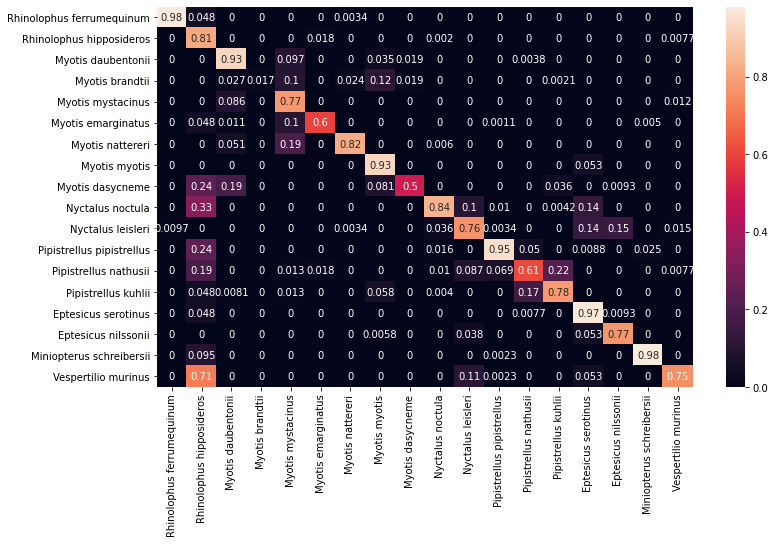

In [19]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot=True)
plt.savefig('BigBAT.png')

In [20]:
corrects = np.equal(Y_pred, Y_true).sum()
single_test_acc = corrects / len(Y_pred)
single_f1 = f1_score(Y_true, Y_pred, average=None).mean()

print("Single test accuracy:", single_test_acc)
print("Single F1-score:", single_f1)

Single test accuracy: 0.8108766233766234
Single F1-score: 0.7443197087711177


In [22]:
wandb.log({
    "mixed_test_acc": mixed_test_acc,
    "mixed_f1_micro": mixed_f1_micro,
    "mixed_f1_macro": mixed_f1_macro,
    "single_test_acc": single_test_acc,
    "single_f1_micro": single_f1,
    "num_params": pytorch_total_params,
})

wandb.finish()

mixed_f1_macro,▁
mixed_f1_micro,▁
mixed_test_acc,▁
num_params,▁
single_f1_micro,▁
single_test_acc,▁
train_acc,▁▃▄▅▅▅▅▆▆▇▇▆▇▇▇▇█▇▇▇███
train_loss,█▆▅▅▄▄▄▃▃▂▂▃▃▂▂▂▂▂▂▂▁▁▁
val_acc,▁▂▄▅▅▅▅▆▆▇▇▆▅▆▇█▇▆▇▇███
val_loss,█▇▆▅▅▅▅▃▃▂▂▃▄▃▂▁▂▄▂▂▁▁▁
mixed_f1_macro,0.6732
